# Ultralong-Range Molecule (ULRM) Electronic State Calculations

This notebook outlines the process of using the Alkali-ULRM platform for performing calculations for ultralong-range molecules (ULRMs). The workflow includes defining basis states, constructing Hamiltonian components, and diagonalizing them to obtain the electronic states. Once the electronic states are calculated, we proceed to calculate R-dependent spin admixture.

---

## Workflow
1. Initialization of the system
2. Basis Construction
   - Rydberg Core Basis (`|alpha>`)
   - Perturber Core Basis (`|beta>`)
3. Hamiltonian Construction
   - Scattering Hamiltonian (Perturber centre)
   - Rydberg Hamiltonian (Rydberg-core centre)
   - Hyperfine Hamiltonian (Rydberg-core centre)
   - Frame transformation
4. Diagonalization
5. Hyperfine Spin admixture
5. Rydberg state admixture

In [8]:
from src import *
from arc import *
import matplotlib.pyplot as plt
import matplotlib.colors as colors

### Initialization
 
Initializing the Building Blocks for ULRM Electronic State Calculations

The initialization process involves defining the following key components:
- **Ground State Atom Species**: Specifies the properties of the ground state atom.
- **Rydberg Atom Species**: Defines the characteristics of the Rydberg atom.
- **Atom-Perturber Scattering Phases**: Includes the scattering phase shifts between the atom and perturber.
- **n_range**: The range of principal quantum numbers (`n_min`, `n_max`).
- **E_range**: The energy range (`E_min`, `E_max`).
- **`Omega`**: The total angular momentum projection.
- **`R`**: Establishes the radial grid for the calculations.

In [20]:
#Load parameters for Rubidium from ARC package
#Rydberg atom
R_atom = Rubidium87()

#Ground state atom
GSatom = Rubidium87()

#Loading atom-electron phase shifts and interpolating them
phase = np.loadtxt('./data/Rb_phase.3016')
phase_shifts = phase_interpolation(phase)

"""Defining the relevant n,E windows, where n0 is the manifold under investigation
here we focus only the n0=18 manifold, but for better accuracy one needs to include a larger n-window
The energy window is defined such that it covers all bound states (quantum-defent splitted) that can be admixed with n0 by the interaction potential."""
n_min,n0,n_max=18,18,18 
E_min,E_max = R_atom.getEnergy(n_min+1, 2, 1.5)/eV, R_atom.getEnergy(n_max,n_max-1,n_max-0.5)/eV #eV -> a.u.

"""Define radial grid R
R[-1] should be large enough to calculate accurate Rydberg wavefunction using numerov scheme"""
R = np.linspace(250,2.6 * n0 * n0 ,400)

#electron wavenumber k in n0 manifold; all k < k_cut assigned 0
k_cut = 0.005
k =np.array([kval(n0,r,k_cut) for r in R])

#Omega = mj + ms2 + mi is the only good quantum number for the system
Omega = 1.5

### Construction of the Electronic Hamiltonian for ULRM Calculations

This section outlines the process of constructing the Hamiltonian for ultralong-range molecules (ULRMs), including:  
1. The Rydberg basis, centered on the Rydberg core (`|alpha>`).  
2. The Scattering basis, centered on the perturber (`|beta>`).  
3. The Hamiltonian components defined in these basis representations.  
4. The transformation between the Scattering basis and the Rydberg core basis.  
5. The calculation of the zero-energy reference.  

In this example, we focus on the special case of a pure singlet p-wave ULRM, using **L=1** and **S=0**.

- To simulate a pure triplet trilobite molecule, use **L=0, S=0**.  
- To simulate a pure triplet butterfly molecule, use **L=1, S=0**.  
- For a complete system (including up to p-wave scattering), use **L=(0, 1), S=(0, 1)**.  

In [27]:
#|alpha> basis centered around the rydberg core
alpha = RydbergBasis(R_atom, n_range = (n_min,n_max), E_range = (E_min,E_max),\
                        Omega  =Omega,GSatom = GSatom).get_basis_states()

"""|beta> basis centered around the perturber core
here we only use L=1, S=0 states for simplicity, limiting ourselves to singlet p-wave scattering configurations.
One could input L=(0,1,) and S=(0,1) to include s- and p-wave, singlet and triplet scattering states."""
beta = ScatteringBasis(Omega,GSatom,L_list=1,S_list=0).get_basis_states()

#Constructing Hamiltonian components
H_U = H_Scattering(beta,k,phase_shifts)
H_ryd = H_Rydberg(alpha,R_atom)
H_hfs = H_Hyperfine(alpha,GSatom)
print("R-independent Hamiltonian components calculated")

A_ab = A_transform(alpha,beta,R)
print(f"R-depdendent frame transformation calculated, size: {A_ab.nbytes/1024**2} MB")

#The zero energy reference for the dimer: ground-state atom hyperfine energy + Rydberg atom energy
A,B = GSatom.getHFSCoefficients(5,0,1/2)
E_hyperfine = GSatom.getHFSEnergyShift(0.5,1,A/10**9)
E_rydberg = R_atom.getEnergy(n0,3,2.5)/eV #eV -> a.u.

R-independent Hamiltonian components calculated
R-depdendent frame transformation calculated, size: 1.55029296875 MB


### Diagonalizing the electronic Hamiltonian
The Hamiltonian matrix is diagonalized to obtain the eigenvalues (`energy`) and eigenstates (`states`) of the system. The diagonalization considers the contributions from the Rydberg Hamiltonian (`H_ryd`), hyperfine Hamiltonian (`H_hfs`), scattering Hamiltonian (`H_U`), and the frame transformation matrix (`A_ab`), all evaluated at each specific internuclear distance `R` (using Born-Oppenheimer approximation)

In [28]:
energy,states = diagonalization(H_ryd,H_hfs,H_U,A_ab,R)
energy = GHz* (energy - E_rydberg) - E_hyperfine

(250.0, 800.0)

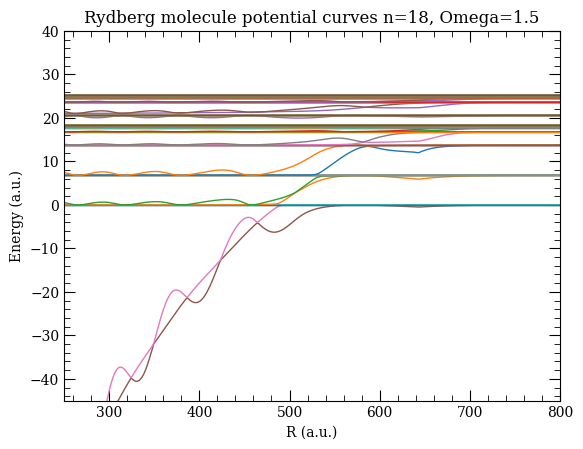

In [60]:
fig,ax = plt.subplots()
ax.plot(R,energy.transpose(),lw=1)
ax.set_xlabel('R (a.u.)')
ax.set_ylabel('Energy (a.u.)')
ax.set_title(f'Rydberg molecule potential curves n={n0}, Omega={Omega}')
ax.set_ylim(-45, 40)  # Set y-axis limits
ax.set_xlim(250, 800)  # Set y-axis limits

### Visualization of F=1 Hyperfine State Admixture

This section calculates and visualizes the admixture of the **F=1 hyperfine state** of the Ground state atom, for each ULRM eigenstate as a function of the internuclear distance `R`.

The **F=1 projector** is defined using the `F_projector` function, and an array `F_admix` is initialized to store the admixture values for each eigenstate. The potential energies are then plotted with their colorbars signifying the F-state admixture.

Note how the adiabtic curves are hyperfine split between the non-degenerate F=1, and F=2 configurations.

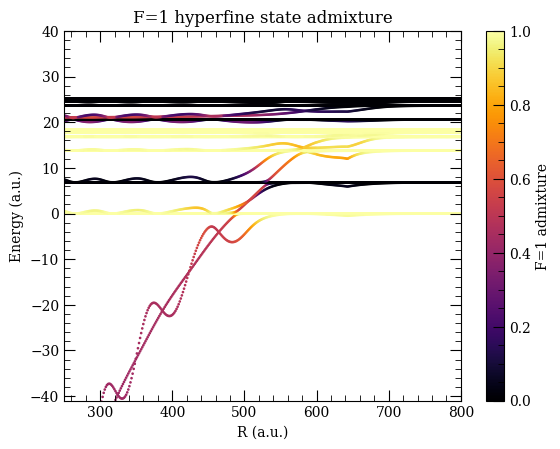

In [61]:
F_proj = F_projector(F = 1, alpha=alpha)
F_admix = np.zeros_like(energy)

for j in range(energy[:,0].size):
    #Calculate S=0 admixture for each eigenstate
    F_admix[j,:] = np.einsum('ar,ab,br->r',states[:,j,:],F_proj,states[:,j,:])

fig,ax = plt.subplots()
norm = colors.Normalize(vmin=np.min(F_admix),vmax=np.max(F_admix))
for j in range(energy[:,0].size):
    cbar = ax.scatter(R, energy[j],cmap='inferno',c=F_admix[j,:],s=0.8,norm=norm)
ax.set_ylim(-41, 40)  
ax.set_xlim(250, 800)  
ax.set_xlabel('R (a.u.)')
ax.set_ylabel('Energy (a.u.)')
ax.set_title('F=1 hyperfine state admixture')
fig.colorbar(cbar,label='F=1 admixture')

### Visualization of 18f (j=5/2) State Admixture

This section calculates and visualizes the admixture of the **18f Rydberg state** for each ULRM eigenstate as a function of the internuclear distance `R`.

#### Step 1: Projector and Admixture Calculation
The **18f Rydberg state projector** is defined using the `Rydberg_projector` function, and an array `Ryd_admix` is initialized to store the admixture values for each eigenstate.

Notice how there are two different dissociation thresholds with maximal state admixture? These are the F=1, and F=2 configurations of the molecule with the Rydberg atom in 18f_5/2 electronic state.


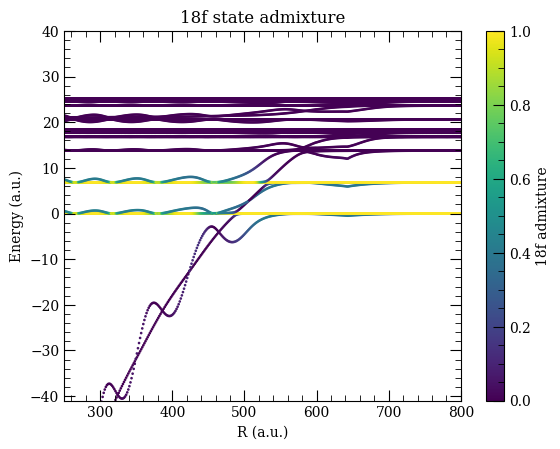

In [58]:
Ryd_proj = Rydberg_projector(n = 18, l=3, j=2.5, alpha=alpha)
Ryd_admix = np.zeros_like(energy)

for j in range(energy[:,0].size):
    #Calculate the 18f state admixture for each eigenstate
    Ryd_admix[j,:] = np.einsum('ar,ab,br->r',states[:,j,:],Ryd_proj,states[:,j,:])

fig,ax = plt.subplots()
norm = colors.Normalize(vmin=np.min(Ryd_admix),vmax=np.max(Ryd_admix))
for j in range(energy[:,0].size):
    cbar =ax.scatter(R, energy[j],cmap='viridis',c=Ryd_admix[j,:],s=0.8,norm=norm)
ax.set_ylim(-41, 40)  
ax.set_xlim(250, 800)  
ax.set_xlabel('R (a.u.)')
ax.set_ylabel('Energy (a.u.)')
ax.set_title('18f state admixture')
fig.colorbar(cbar,label='18f admixture')